# GIS operations

Geographic Information System (GIS) operations are crucial in hydrological analysis. This section illustrates how to leverage the `xHydro` library for performing key GIS tasks, including delineating watershed boundaries and extracting critical physiographic, climatological, and geographical variables at the watershed scale.

In [1]:
import leafmap
import numpy as np
import pandas as pd
import xarray as xr
import xclim
import xdatasets
from IPython.display import clear_output

import xhydro as xh
import xhydro.gis as xhgis

clear_output(wait=False)

## Watershed delineation

Currently, watershed delineation utilizes HydroSHEDS' [HydroBASINS](https://www.hydrosheds.org/products/hydrobasins) (hybas_na_lev01-12_v1c) and is compatible with any location in North America. The process involves identifying all upstream sub-basins from a specified outlet and consolidating them into a unified watershed. The [leafmap](https://leafmap.org/) library is used to generate interactive maps, which allow for the selection of outlets or the visualization of the resulting watershed boundaries. While the use of the map is not mandatory for performing the calculations, it greatly enhances the visualization and understanding of the watershed delineation process.

In [2]:
m = leafmap.Map(center=(48.63, -74.71), zoom=5, basemap="USGS Hydrography")

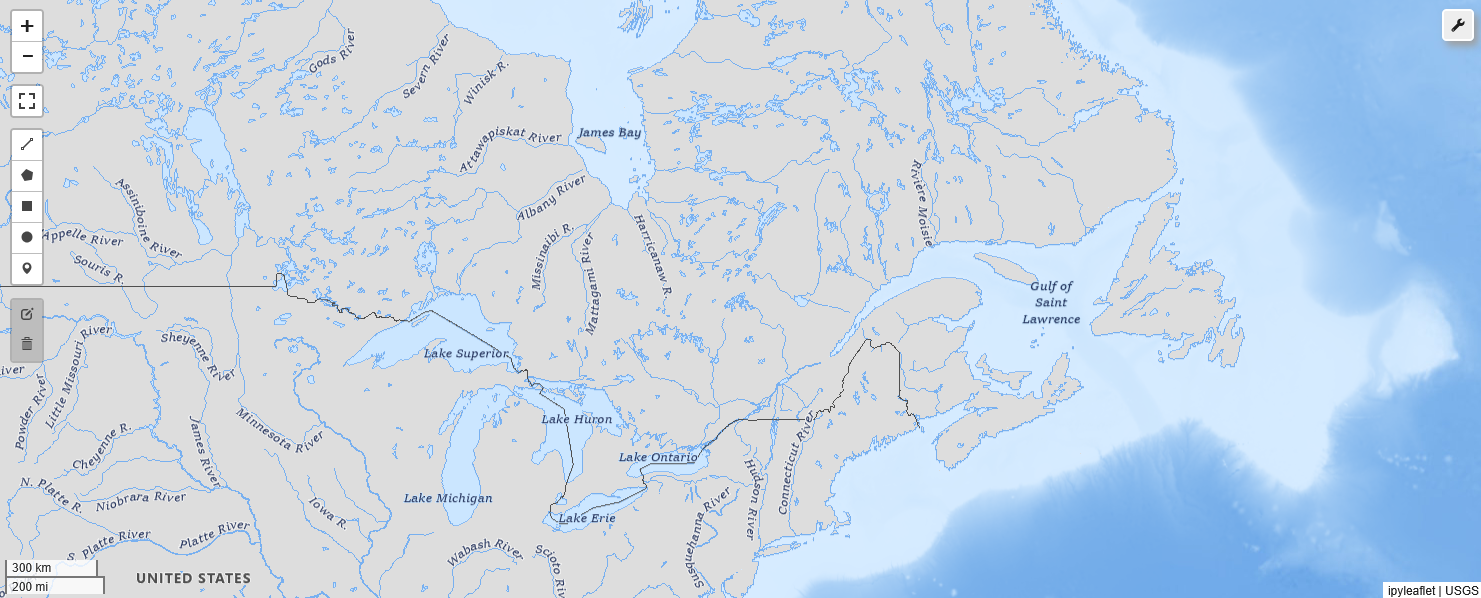

### a) From a list of coordinates
A first option is to provide a list of coordinates. In the example below, we select two pour points, with each one representing the outlet for the watersheds of Montmorency and the Beaurivage River, respectively.

In [3]:
lng_lat = [
    (-71.15069, 46.89431),  # Montmorency river watershed
    (-71.28512, 46.66141),  # Beaurivage river watershed
]

### b) From markers on a map

Rather than using a list, a more interactive approach allows for directly selecting outlets from the existing map `m`, using the `Draw a marker` button located on the left of the map. The image below demonstrates how to select pour points by dragging markers to the desired locations on the map.

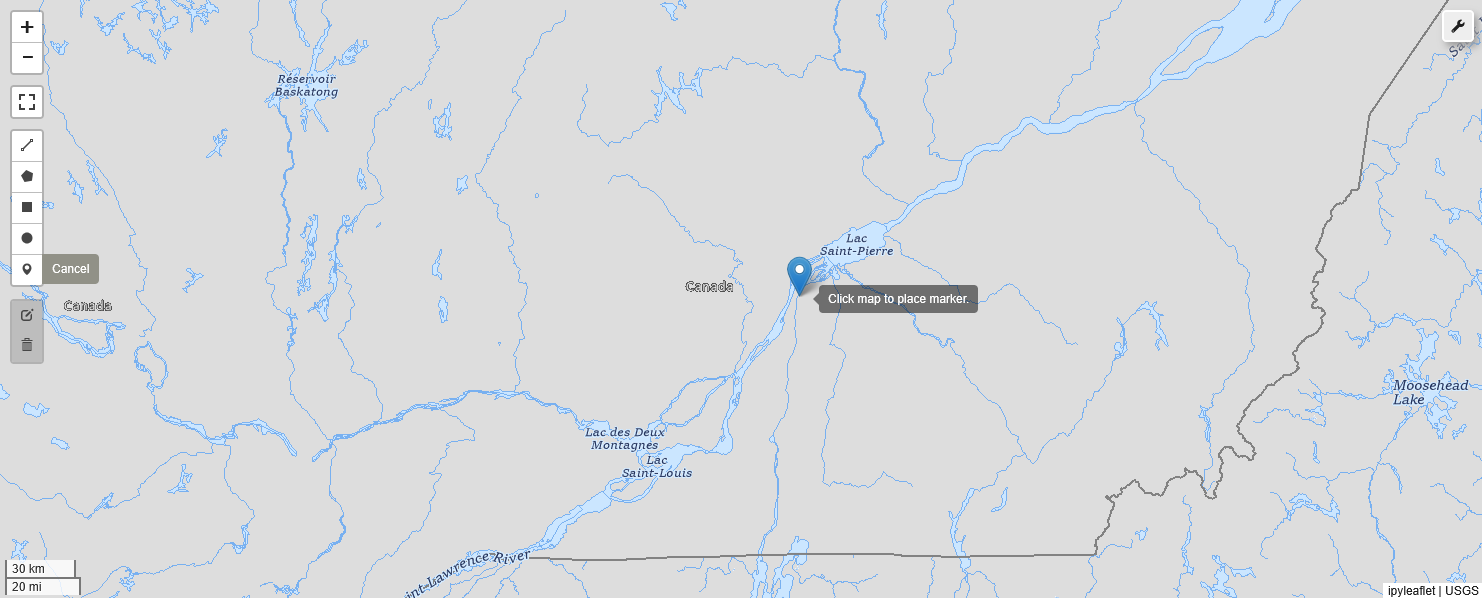

After selecting points using either approach a) or b), or a combination of both, we can initiate the watershed delineation calculation. This is done using the function `xhydro.gis.watershed_delineation`.

In [4]:
help(xhgis.watershed_delineation)

Help on function watershed_delineation in module xhydro.gis:

watershed_delineation(*, coordinates: 'list[tuple] | tuple | None' = None, m: 'leafmap.Map | None' = None, map: 'leafmap.Map | None' = None) -> 'gpd.GeoDataFrame'
    Calculate watershed delineation from pour point.

    Watershed delineation can be computed at any location in North America using HydroBASINS (hybas_na_lev01-12_v1c).
    The process involves assessing all upstream sub-basins from a specified pour point and consolidating them into a
    unified watershed.

    Parameters
    ----------
    coordinates : list of tuple, tuple, optional
        Geographic coordinates (longitude, latitude) for the location where watershed delineation will be conducted.
    m : leafmap.Map, optional
        If the function receives both a map and coordinates as inputs, it will generate and display watershed
        boundaries on the map. Additionally, any markers present on the map will be transformed into
        corresponding wat

In [5]:
gdf = xhgis.watershed_delineation(coordinates=lng_lat, m=m)
gdf

,HYBAS_ID,Upstream Area (sq. km).,geometry,category,color
0,7120034480,1157.6,"POLYGON ((-71.15208 46.8838, -71.15612 46.8869...",5,#081d58
1,7120365812,693.5,"POLYGON ((-71.09758 46.40035, -71.09409 46.403...",1,#ffffd9


The outcomes are stored in a GeoPandas `gpd.GeoDataFrame` object, enabling us to save the polygons in various common formats, such as ESRI Shapefile or GeoJSON. If a map `m` is available, the polygons will be automatically added to it. To visualize the map, simply type `m` in the code cell to render it. If displaying the map directly is not compatible with your notebook interpreter, you can use the following code to extract the HTML from the map and plot it:

In [6]:
m.zoom_to_gdf(gdf)

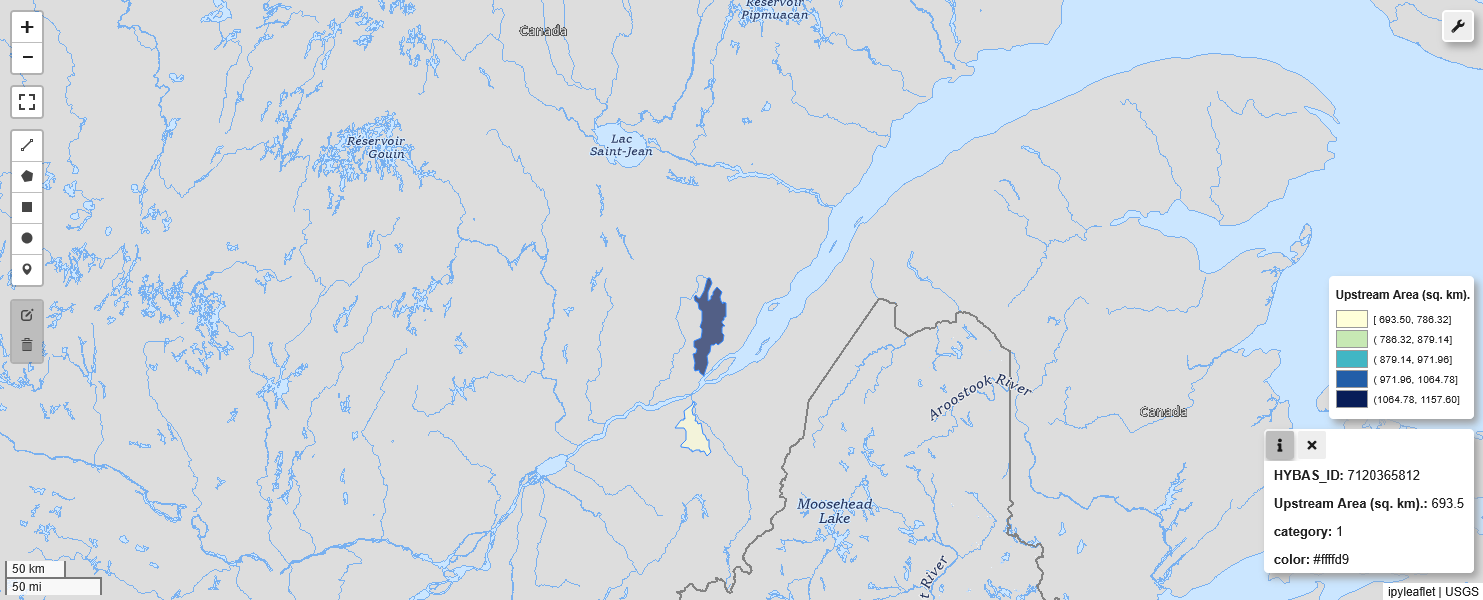

### c) From [xdatasets](https://github.com/hydrologie/xdatasets)

While automatically delineating watershed boundaries is a valuable tool, users are encouraged to utilize official watershed boundaries when available, rather than generating new ones. The [xdatasets](https://github.com/hydrologie/xdatasets) library, for example, hosts a few official boundaries that can be accessed using the `xdatasets.Query` function. As of today, the following watershed sources are available:

| Source                                                                                                                                                             | Dataset name   |
|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------|
| [(Canada) National Water Data Archive: HYDAT](https://www.canada.ca/en/environment-climate-change/services/water-overview/quantity/monitoring/survey/data-products-services/national-archive-hydat.html) | hydat_polygons |
| [(Quebec) Provincial Ministry of Environment (MELCCFP/DPEH)](https://www.cehq.gouv.qc.ca/atlas-hydroclimatique/stations-hydrometriques/index.htm)                                                                         | deh_polygons   |
| [(Quebec) Hydro-Quebec](https://www.hydroquebec.com/)                                                                                                                                | hq_polygons    |


In [7]:
xdatasets.Query(
    **{
        "datasets": {
            "deh_polygons": {
                "id": ["031502", "0421*"],
                "regulated": ["Natural"],
            }
        }
    }
).data.reset_index()

,Station,Superficie,geometry
0,031502,15.708960,"POLYGON ((-72.50126 46.21216, -72.50086 46.213..."
1,042103,579.479614,"POLYGON ((-78.49014 46.64514, -78.4901 46.6450..."


## Extraction of watershed properties

Once the watershed boundaries are obtained, we can extract valuable properties such as geographical information, land use classification, and climatological data from the delineated watersheds.

### a) Geographical watershed properties

First, `xhydro.gis.watershed_properties` can be used to extract the geographical properties of the watershed, including the perimeter, total area, Gravelius coefficient, and basin centroid. It is important to note that this function returns all the columns present in the provided `gpd.GeoDataFrame` argument.

In [8]:
help(xhgis.watershed_properties)

Help on function watershed_properties in module xhydro.gis:

watershed_properties(gdf: 'gpd.GeoDataFrame', *, unique_id: 'str | None' = None, projected_crs: 'int | str | None' = 'NAD83', output_format: "Literal['xarray', 'xr.Dataset', 'geopandas', 'gpd.GeoDataFrame']" = 'geopandas') -> 'gpd.GeoDataFrame | xr.Dataset'
    Watershed properties extracted from a gpd.GeoDataFrame.

    The calculated properties are :
    - area
    - perimeter
    - gravelius
    - centroid coordinates

    Parameters
    ----------
    gdf : gpd.GeoDataFrame
        GeoDataFrame containing watershed polygons. Must have a defined .crs attribute.
    unique_id : str, optional
        The column name in the GeoDataFrame that serves as a unique identifier.
    projected_crs : int | str
        The projected coordinate reference system (crs) to utilize for calculations, such as determining watershed area.
        If a string is provided, it should be a valid Geodetic CRS for the `gpd.estimate_utm_crs()` method.

In [9]:
xhgis.watershed_properties(gdf)

,HYBAS_ID,Upstream Area (sq. km).,category,color,area (m2),estimated_area_diff (%),perimeter (m),gravelius (m/m),centroid_lon,centroid_lat
0,7120034480,1157.6,5,#081d58,1.160550e+09,0.254842,263428.762122,2.181355,-71.091980,47.257839
1,7120365812,693.5,1,#ffffd9,5.855856e+08,-15.560840,158295.639822,1.845308,-71.260464,46.452161


For added convenience, we can also retrieve the same results in the form of an `xarray.Dataset`:

In [10]:
xhgis.watershed_properties(gdf, unique_id="HYBAS_ID", output_format="xarray")

<xarray.Dataset> Size: 160B
Dimensions:                  (HYBAS_ID: 2)
Coordinates:
  * HYBAS_ID                 (HYBAS_ID) int64 16B 7120034480 7120365812
Data variables:
    Upstream Area (sq. km).  (HYBAS_ID) float64 16B 1.158e+03 693.5
    category                 (HYBAS_ID) int64 16B 5 1
    color                    (HYBAS_ID) object 16B '#081d58' '#ffffd9'
    area                     (HYBAS_ID) float64 16B 1.161e+09 5.856e+08
    estimated_area_diff      (HYBAS_ID) float64 16B 0.2548 -15.56
    perimeter                (HYBAS_ID) float64 16B 2.634e+05 1.583e+05
    gravelius                (HYBAS_ID) float64 16B 2.181 1.845
    centroid_lon             (HYBAS_ID) float64 16B -71.09 -71.26
    centroid_lat             (HYBAS_ID) float64 16B 47.26 46.45

### b) Surface properties

We can use `xhydro.gis.surface_properties` to extract surface properties for the same `gpd.GeoDataFrame`, such as slope and aspect. By default, these properties are calculated using [Copernicus' GLO-90 Digital Elevation Model](https://portal.opentopography.org/raster?opentopoID=OTSDEM.032021.4326.1) as of 2021-04-22. However, both the source and the date can be modified through the function's arguments.

In [11]:
help(xhgis.surface_properties)

Help on function surface_properties in module xhydro.gis:

surface_properties(gdf: 'gpd.GeoDataFrame', *, unique_id: 'str | None' = None, projected_crs: 'int | str | None' = 'NAD83', operation: 'str' = 'mean', dataset_date: 'str' = '2021-04-22', collection: 'str' = 'cop-dem-glo-90', output_format: "Literal['xarray', 'xr.Dataset', 'geopandas', 'gpd.GeoDataFrame']" = 'geopandas') -> 'gpd.GeoDataFrame | xr.Dataset'
    Surface properties for watersheds.

    Surface properties are calculated using Copernicus's GLO-90 Digital Elevation Model.
    By default, the dataset has a geographic coordinate system (EPSG: 4326) and this function expects a projected crs for more accurate results.

    The calculated properties are :
    - elevation (meters)
    - slope (degrees)
    - aspect ratio (degrees)

    Parameters
    ----------
    gdf : gpd.GeoDataFrame
        GeoDataFrame containing watershed polygons. Must have a defined .crs attribute.
    unique_id : str, optional
        The column na

In [12]:
xhgis.surface_properties(gdf)

,elevation,slope,aspect
geometry,,,
0,724.399536,5.567540,186.280136
1,223.501282,1.420346,213.184433


Again, for convenience, we can output the results in `xarray.Dataset` format :

In [13]:
xhgis.surface_properties(gdf, unique_id="HYBAS_ID", output_format="xarray")

<xarray.Dataset> Size: 56B
Dimensions:    (HYBAS_ID: 2)
Coordinates:
    geometry   (HYBAS_ID) geometry 16B POLYGON ((336034.51117111975 5194499.9...
  * HYBAS_ID   (HYBAS_ID) int64 16B 7120034480 7120365812
Data variables:
    elevation  (HYBAS_ID) float32 8B 724.4 223.5
    slope      (HYBAS_ID) float32 8B 5.568 1.42
    aspect     (HYBAS_ID) float32 8B 186.3 213.2
Attributes:
    spec:         RasterSpec(epsg=4326, bounds=(-72.00083333333333, 46.0, -70...
    resolution:   0.0008333333333333334
    _FillValue:   nan
    platform:     TanDEM-X
    gsd:          90
    time:         2021-04-22T00:00:00.000000000
    band:         data
    proj:shape:   {1200}
    proj:code:    EPSG:4326
    epsg:         4326
    spatial_ref:  0

### c) Land use classification

Finally, we can retrieve land use classifications using `xhydro.gis.land_use_classification`. This function is powered by the Planetary Computer's STAC catalog and, by default, uses the [10m Annual Land Use Land Cover (9-class) V2](https://planetarycomputer.microsoft.com/dataset/io-lulc-annual-v02) dataset ("io-lulc-annual-v02"). However, alternative collections can be specified as arguments to the function.


In [14]:
help(xhgis.land_use_classification)

Help on function land_use_classification in module xhydro.gis:

land_use_classification(gdf: 'gpd.GeoDataFrame', *, unique_id: 'str | None' = None, collection='io-lulc-annual-v02', year: 'str | int' = 'latest', output_format: "Literal['xarray', 'xr.Dataset', 'geopandas', 'gpd.GeoDataFrame']" = 'geopandas') -> 'gpd.GeoDataFrame | xr.Dataset'
    Calculate land use classification.

    Calculate land use classification for each polygon from a gpd.GeoDataFrame. By default,
    the classes are generated from the Planetary Computer's STAC catalog using the
    `10m Annual Land Use Land Cover` dataset.

    Parameters
    ----------
    gdf : gpd.GeoDataFrame
        GeoDataFrame containing watershed polygons. Must have a defined .crs attribute.
    unique_id : str
        GeoDataFrame containing watershed polygons. Must have a defined .crs attribute.
    collection : str
        Collection name from the Planetary Computer STAC Catalog.
    year : str | int
        Land use dataset year betw

In [15]:
df = xhgis.land_use_classification(gdf, unique_id="HYBAS_ID", output_format="xarray")
df

  0%|          | 0/2 [00:00<?, ?it/s]

<xarray.Dataset> Size: 160B
Dimensions:                 (HYBAS_ID: 2)
Coordinates:
  * HYBAS_ID                (HYBAS_ID) int64 16B 7120034480 7120365812
Data variables:
    pct_trees               (HYBAS_ID) float64 16B 0.9088 0.5993
    pct_water               (HYBAS_ID) float64 16B 0.02161 0.002931
    pct_snow/ice            (HYBAS_ID) float64 16B 0.0005295 0.0002913
    pct_rangeland           (HYBAS_ID) float64 16B 0.05133 0.08352
    pct_flooded_vegetation  (HYBAS_ID) float64 16B 0.0001867 0.0
    pct_bare_ground         (HYBAS_ID) float64 16B 0.0001114 6.758e-05
    pct_crops               (HYBAS_ID) float64 16B 0.0002994 0.277
    pct_built_area          (HYBAS_ID) float64 16B 0.01713 0.03679
    pct_clouds              (HYBAS_ID) float64 16B 0.0 6.031e-05
Attributes:
    year:                2023
    collection:          io-lulc-annual-v02
    spatial_resolution:  10

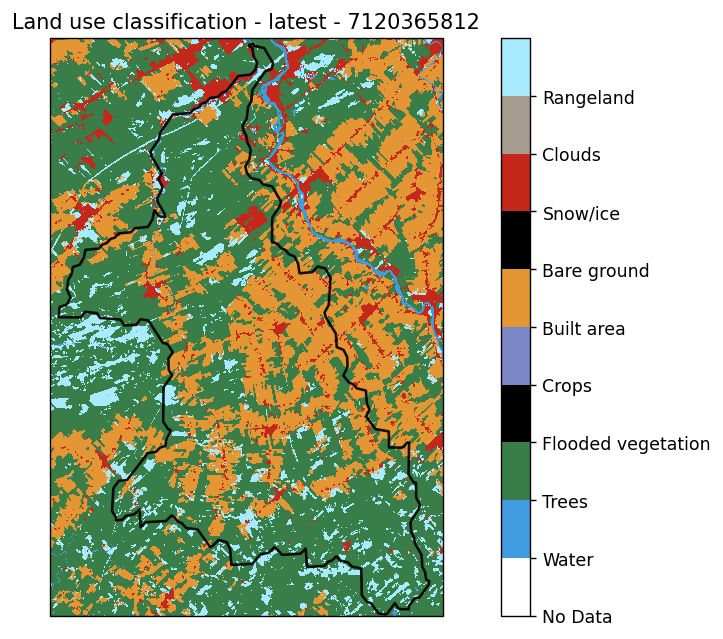

In [16]:
ax = xhgis.land_use_plot(gdf, unique_id="HYBAS_ID", idx=1)

### d) Climate indicators

The extraction of climate indicators is the most complex step, as it requires accessing a weather dataset, then subsetting and averaging the data over the various watersheds within the `GeoDataFrame` object. These steps are outside the scope of `xHydro`, and users will need to rely on other libraries for this task. One approach, outlined in the [Use Case Example](use_case.ipynb), involves using a combination of `xscen` and `xESMF`. Another approach, demonstrated here, utilizes `xdatasets`. Indeed, `xdatasets` enables the extraction of all the pixels from a gridded dataset within a watershed while accounting for the weighting of each pixel intersecting the watershed.

For this example, we will use ERA5-Land reanalysis data covering the period from 1981 to 2010 as our climatological dataset.


In [17]:
datasets = {
    "era5_land_reanalysis": {"variables": ["t2m", "tp"]},
}
space = {
    "clip": "polygon",  # bbox, point or polygon
    "averaging": True,
    "geometry": gdf,
    "unique_id": "HYBAS_ID",
}
time = {
    "start": "1981-01-01",
    "end": "1982-12-31",
    "timezone": "America/Montreal",
    "timestep": "D",
    "aggregation": {"tp": np.nansum, "t2m": np.nanmean},
}

ds = xdatasets.Query(datasets=datasets, space=space, time=time).data.squeeze()

0it [00:00, ?it/s]

Temporal operations: processing tp with era5_land_reanalysis: 100%|██████████████████████████████████████████| 2/2 [00:00<00:00,  6.47it/s]


Because the next steps utilize [xclim](https://xclim.readthedocs.io/en/stable/index.html) under the hood, the dataset must be [CF-compliant](https://cfconventions.org/cf-conventions/cf-conventions.html). At a minimum, the `xarray.DataArray` used should adhere to the following principles:

- The dataset must include a `time` dimension, typically at a daily frequency, with no missing timesteps (although NaNs are supported). If your data deviates from this format, extra caution should be taken when interpreting the results.
- If there is a 1D spatial dimension, such as `HYBAS_ID` in the example below, it must have an attribute `cf_role` with the value `timeseries_id`.
- The variable must include at least a `units` attribute. While not mandatory, other attributes such as `long_name` and `cell_methods` are expected by `xclim`, and warnings will be raised if they are missing.
- Variable names should match those supported by `xclim`.

The following code will format the ERA5-Land data obtained from `xdatasets` to add missing metadata and change the variable names and units:


In [18]:
ds = ds.rename({"t2m_nanmean": "tas", "tp_nansum": "pr"})
ds["tas"] = xclim.core.units.convert_units_to(ds["tas"], "degC")
ds["tas"].attrs.update({"cell_methods": "time: mean"})

ds["pr"].attrs.update({"units": "m d-1", "cell_methods": "time: mean within days"})
ds["pr"] = xclim.core.units.convert_units_to(ds["pr"], "mm d-1")
ds

<xarray.Dataset> Size: 29kB
Dimensions:      (HYBAS_ID: 2, time: 730)
Coordinates:
    spatial_agg  <U7 28B 'polygon'
    timestep     <U1 4B 'D'
  * HYBAS_ID     (HYBAS_ID) int64 16B 7120034480 7120365812
  * time         (time) datetime64[ns] 6kB 1981-01-01 1981-01-02 ... 1982-12-31
    source       <U20 80B 'era5_land_reanalysis'
Data variables:
    tas          (HYBAS_ID, time) float64 12kB -19.64 -15.9 ... -6.387 -5.33
    pr           (HYBAS_ID, time) float64 12kB 0.01237 3.258 ... 0.07566 0.176
Attributes: (12/30)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1171
    GRIB_Ny:                                  701
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            fc
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    K

Climate indicators can be calculated in various ways, and for most simple tasks, directly using `xclim` is always a viable option. `xclim` offers an extensive [list of available indicators](https://xclim.readthedocs.io/en/stable/indicators.html) within a user-friendly and flexible framework.


In [19]:
xclim.atmos.tg_max(ds.tas)

<xarray.DataArray 'tg_max' (HYBAS_ID: 2, time: 2)> Size: 32B
array([[292.65401005, 295.1619582 ],
       [296.13479571, 298.57350323]])
Coordinates:
    spatial_agg  <U7 28B 'polygon'
    timestep     <U1 4B 'D'
  * HYBAS_ID     (HYBAS_ID) int64 16B 7120034480 7120365812
    source       <U20 80B 'era5_land_reanalysis'
  * time         (time) datetime64[ns] 16B 1981-01-01 1982-01-01
Attributes:
    units:           K
    units_metadata:  temperature: unknown
    cell_methods:    time: mean time: maximum over days
    history:         [2025-05-27 12:55:08] tg_max: TG_MAX(tas=tas, freq='YS')...
    standard_name:   air_temperature
    long_name:       Maximum daily mean temperature
    description:     Annual maximum of daily mean temperature.

For more complex tasks, or when computing multiple indicators simultaneously, `xhydro.indicators.compute_indicators` is often the preferred method. This function allows users to build and pass multiple indicators at once, either by providing a list of custom indicators created with `xclim.core.indicator.Indicator.from_dict` (see the INFO box below) or by referencing a YAML file (see [the `xscen` documentation](https://xscen.readthedocs.io/en/latest/notebooks/2_getting_started.html#Computing-indicators)).


<div class="alert alert-info"> <b>INFO</b>

Custom indicators in `xHydro` are built by following the YAML formatting required by `xclim`.

A custom indicator built using `xclim.core.indicator.Indicator.from_dict` will need these elements:

- "data": A dictionary with the following information:
  - "base": The "YAML ID" obtained from [here](https://xclim.readthedocs.io/en/stable/indicators.html).
  - "input": A dictionary linking the default xclim input to the name of your variable. Needed only if it is different. In the link above, they are the string following "Uses:".
  - "parameters": A dictionary containing all other parameters for a given indicator. In the link above, the easiest way to access them is by clicking the link in the top-right corner of the box describing a given indicator.
  - More entries can be used here, as described [in the xclim documentation](https://xclim.readthedocs.io/en/latest/api.html#yaml-file-structure) under "identifier".
- "identifier": A custom name for your indicator. This will be the name returned in the results.
- "module": Needed, but can be anything. To prevent an accidental overwriting of `xclim` indicators, it is best to use something different from: ["atmos", "land", "generic"].

</div>

In [20]:
help(xh.indicators.compute_indicators)

Help on function compute_indicators in module xscen.indicators:

compute_indicators(ds: xarray.core.dataset.Dataset, indicators: str | os.PathLike | collections.abc.Sequence[xclim.core.indicator.Indicator] | collections.abc.Sequence[tuple[str, xclim.core.indicator.Indicator]] | module, *, periods: list[str] | list[list[str]] | None = None, restrict_years: bool = True, to_level: str | None = 'indicators', rechunk_input: bool = False) -> dict
    Calculate variables and indicators based on a YAML call to xclim.

    The function cuts the output to be the same years as the inputs.
    Hence, if an indicator creates a timestep outside the original year range (e.g. the first DJF for QS-DEC),
    it will not appear in the output.

    Parameters
    ----------
    ds : xr.Dataset
        Dataset to use for the indicators.
    indicators : str | os.PathLike | Sequence[Indicator] | Sequence[tuple[str, Indicator]] | ModuleType
        Path to a YAML file that instructs on how to calculate missi

In [21]:
indicators = [
    # Maximum summer temperature
    xclim.core.indicator.Indicator.from_dict(
        data={
            "base": "tg_max",
            "parameters": {"indexer": {"month": [6, 7, 8]}},
        },
        identifier="tg_max_summer",
        module="example",
    ),
    # Number of days with more than 5 mm of precipitation
    xclim.core.indicator.Indicator.from_dict(
        data={
            "base": "wetdays",
            "parameters": {"thresh": "5 mm d-1"},
        },
        identifier="wet5mm",
        module="example",
    ),
]

xh.indicators.compute_indicators(ds, indicators)["YS-JAN"]

<xarray.Dataset> Size: 208B
Dimensions:        (HYBAS_ID: 2, time: 2)
Coordinates:
    spatial_agg    <U7 28B 'polygon'
    timestep       <U1 4B 'D'
  * HYBAS_ID       (HYBAS_ID) int64 16B 7120034480 7120365812
    source         <U20 80B 'era5_land_reanalysis'
  * time           (time) datetime64[ns] 16B 1981-01-01 1982-01-01
Data variables:
    tg_max_summer  (HYBAS_ID, time) float64 32B 292.7 295.2 296.1 298.6
    wet5mm         (HYBAS_ID, time) float64 32B 85.0 83.0 80.0 78.0
Attributes: (12/34)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1171
    GRIB_Ny:                                  701
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            fc
    ...                                       ...
    standard_name:                            unknown
    units:                                    K
    cat:xrfreq:                               YS-JAN
    cat:frequency:                            yr
    cat:processing_level:                     indicators
    cat:variable:                             ('tg_max_summer', 'wet5mm')

Finally, `xhydro.indicators.get_yearly_op`, also built upon the `xclim` library, provides a flexible method for obtaining yearly values of specific statistics, such as annual or seasonal maxima. This can be particularly useful, for instance, when extracting raw data needed for frequency analyses.


In [22]:
help(xh.indicators.get_yearly_op)

Help on function get_yearly_op in module xhydro.indicators.generic:

get_yearly_op(ds, op, *, input_var: str = 'q', window: int = 1, timeargs: dict | None = None, missing: str = 'skip', missing_options: dict | None = None, interpolate_na: bool = False) -> xarray.core.dataset.Dataset
    Compute yearly operations on a variable.

    Parameters
    ----------
    ds : xr.Dataset
        Dataset containing the variable to compute the operation on.
    op : str
        Operation to compute. One of ["max", "min", "mean", "sum"].
    input_var : str
        Name of the input variable. Defaults to "q".
    window : int
        Size of the rolling window. A "mean" operation is performed on the rolling window before the call to xclim.
        This parameter cannot be used with the "sum" operation.
    timeargs : dict, optional
        Dictionary of time arguments for the operation.
        Keys are the name of the period that will be added to the results (e.g. "winter", "summer", "annual").
   

The `timeargs` argument relies on indexers that are compatible with `xclim.core.calendar.select_time`. Four types of indexers are currently accepted:

- `month`, followed by a sequence of month numbers.
- `season`, followed by one or more of `'DJF'`, `'MAM'`, `'JJA'`, and `'SON'`.
- `doy_bounds`, followed by a sequence representing the inclusive bounds of the period to be considered (`'start'`, `'end'`).
- `date_bounds`, similar to `doy_bounds`, but using a month-day (`'%m-%d'`) format.

Subsequently, we specify the operations to be calculated for each variable. Supported operations include `"max"`, `"min"`, `"mean"`, and `"sum"`.


In [23]:
timeargs = {
    "january": {"month": [1]},
    "spring": {"date_bounds": ["02-11", "06-19"]},
    "summer_fall": {"date_bounds": ["06-20", "11-19"]},
    "year": {"date_bounds": ["01-01", "12-31"]},
}

operations = {
    "tas": ["max", "mean"],
    "pr": ["sum"],
}

The combination of `timeargs` and `operations` through the Cartesian product enables the efficient generation of a comprehensive array of climate indicators.

In [24]:
ds_climatology = xr.merge(
    [
        xh.indicators.get_yearly_op(ds, input_var=variable, op=op, timeargs=timeargs)
        for (variable, ops) in operations.items()
        for op in ops
    ]
)
ds_climatology

<xarray.Dataset> Size: 528B
Dimensions:               (HYBAS_ID: 2, time: 2)
Coordinates:
    spatial_agg           <U7 28B 'polygon'
    timestep              <U1 4B 'D'
  * HYBAS_ID              (HYBAS_ID) int64 16B 7120034480 7120365812
    source                <U20 80B 'era5_land_reanalysis'
  * time                  (time) datetime64[ns] 16B 1981-01-01 1982-01-01
Data variables:
    tas_max_january       (HYBAS_ID, time) float64 32B -4.165 -7.795 ... -3.176
    tas_max_spring        (HYBAS_ID, time) float64 32B 17.11 18.26 21.04 20.31
    tas_max_summer_fall   (HYBAS_ID, time) float64 32B 19.5 22.01 22.98 25.42
    tas_max_year          (HYBAS_ID, time) float64 32B 19.5 22.01 22.98 25.42
    tas_mean_january      (HYBAS_ID, time) float64 32B -18.11 -19.82 ... -16.8
    tas_mean_spring       (HYBAS_ID, time) float64 32B 1.696 -0.8479 5.592 2.777
    tas_mean_summer_fall  (HYBAS_ID, time) float64 32B 9.367 9.219 12.23 12.57
    tas_mean_year         (HYBAS_ID, time) float64 32B 1.734 0.5356 4.881 4.094
    pr_sum_january        (HYBAS_ID, time) float64 32B 34.29 88.93 28.49 85.93
    pr_sum_spring         (HYBAS_ID, time) float64 32B 591.9 343.5 453.4 333.9
    pr_sum_summer_fall    (HYBAS_ID, time) float64 32B 603.6 626.1 743.2 535.9
    pr_sum_year           (HYBAS_ID, time) float64 32B 1.417e+03 ... 1.163e+03
Attributes: (12/35)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1171
    GRIB_Ny:                                  701
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            fc
    ...                                       ...
    units:                                    K
    cat:xrfreq:                               YS-JAN
    cat:frequency:                            yr
    cat:processing_level:                     indicators
    cat:variable:                             ('tas_max_january', 'tas_max_sp...
    cat:id:

The same data can also be visualized as a `pd.DataFrame` as well :

In [25]:
pd.set_option("display.max_rows", 100)
ds_climatology.mean("time").to_dataframe().T

HYBAS_ID,7120034480,7120365812
spatial_agg,polygon,polygon
timestep,D,D
source,era5_land_reanalysis,era5_land_reanalysis
tas_max_january,-5.979976,-1.652047
tas_max_spring,17.686927,20.677712
tas_max_summer_fall,20.757984,24.204149
tas_max_year,20.757984,24.204149
tas_mean_january,-18.967689,-16.441736
tas_mean_spring,0.424023,4.184447
tas_mean_summer_fall,9.293055,12.396911
